# Python Example

In [2]:
import numpy as np
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



First we load data on the risk-free rate and convert to daily returns:


In [3]:
coin = 'BTC/USDT'
binance = ccxt.binance()
btc_ticker = binance.fetch_ticker(coin)
btc_usdt_ohlcv = binance.fetch_ohlcv(coin,'5m',limit=100)
df=pd.DataFrame(btc_usdt_ohlcv,columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'], unit = 'ms' )

Next we load details on BTC returns:

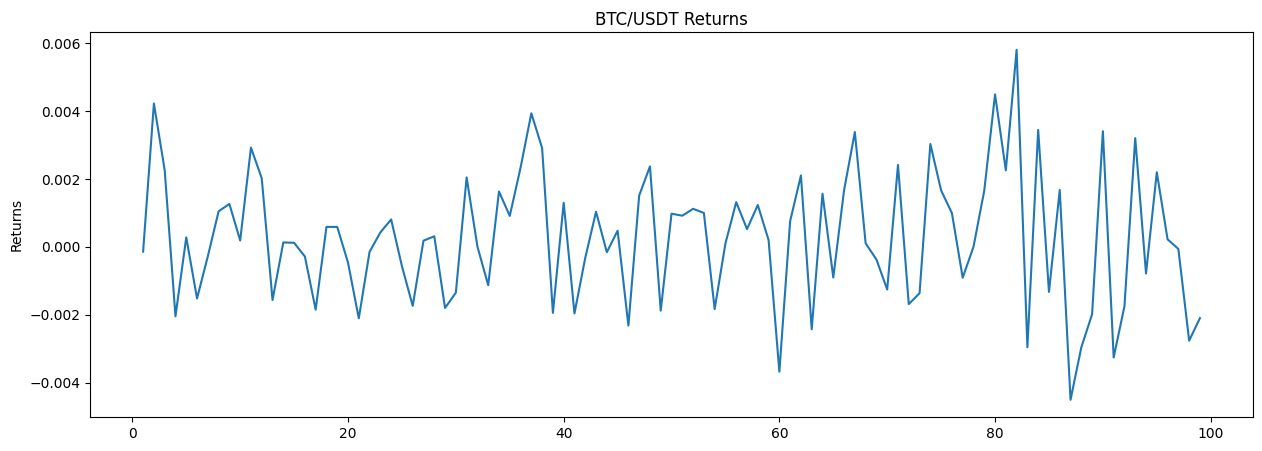

In [4]:
coin_returns = pd.DataFrame(np.diff(np.log(df['Close'].values)))
coin_returns.index = df.index.values[1:df.index.values.shape[0]]
coin_returns.columns = [f'{coin} Returns']

plt.figure(figsize=(15,5))
plt.plot(coin_returns)
plt.ylabel('Returns')
plt.title(f'{coin} Returns')
plt.show()

We'll calculate returns an example stock that's listed on this index - for example, BNB:

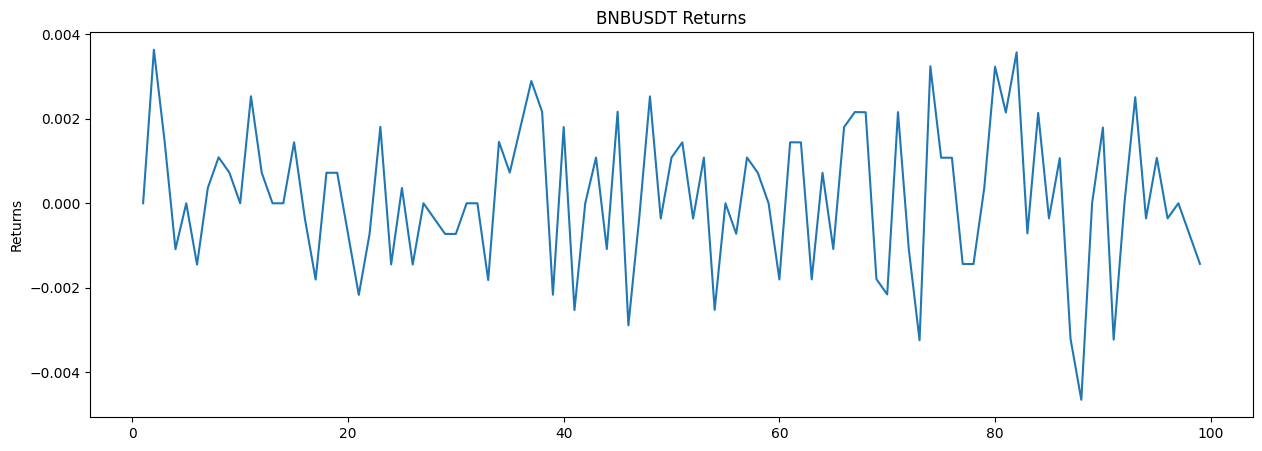

In [5]:
coin2 = 'BNBUSDT'
bnb_ticker = binance.fetch_ticker(coin2)
bnb_usdt_ohlcv = binance.fetch_ohlcv(coin2,'5m',limit=100)
df1=pd.DataFrame(bnb_usdt_ohlcv,columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df1['Date'] = pd.to_datetime(df['Date'], unit = 'ms' )
coin2_returns = pd.DataFrame(np.diff(np.log(df1['Close'].values)))
coin2_returns.index = df1.index.values[1:df1.index.values.shape[0]]
coin2_returns.columns = [f'{coin2} Returns']

plt.figure(figsize=(15,5))
plt.plot(coin2_returns)
plt.ylabel('Returns')
plt.title(f'{coin2} Returns')
plt.show()




Next we need to merge the series to make sure they are all on the same timescale and then calculate the excess returns:


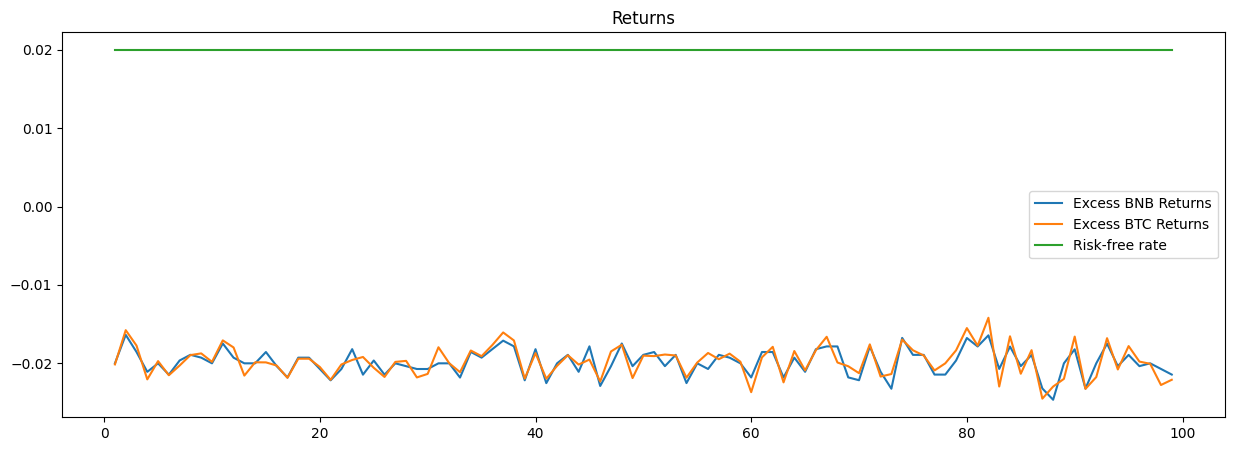

In [6]:
returns = pd.concat([coin_returns,coin2_returns],axis=1).dropna()
risk_free_rate = 0.02  # we are considering this
risk_free_rate = np.array([risk_free_rate]*len(returns))
excess_bnb = returns["BNBUSDT Returns"].values - risk_free_rate
excess_btc = returns["BTC/USDT Returns"].values - risk_free_rate
final_returns = pd.DataFrame(np.transpose([excess_bnb,excess_btc, risk_free_rate]))
final_returns.columns=["Excess BNB Returns","Excess BTC Returns","Risk-free rate"]
final_returns.index = returns.index
plt.figure(figsize=(15,5))
plt.title("Returns")
x = plt.plot(final_returns)
plt.legend(iter(x), final_returns.columns)

Now we will perform a linear regression using the two series:

In [7]:
import statsmodels.api as sm

exog = excess_btc
exog = sm.add_constant(exog, prepend=True)
mod = sm.OLS(excess_bnb, exog)
res = mod.fit()
print(res.summary())
     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     265.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.70e-29
Time:                        09:08:05   Log-Likelihood:                 558.14
No. Observations:                  99   AIC:                            -1112.
Df Residuals:                      97   BIC:                            -1107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.001     -6.138      0.0

From this Beta(M)=-0.0131 and alpha = -0.003, although the latter is not statistically significant - this is consistent with CAPM which predicts no excess expected residual returns.

Using these results we can split the excess returns into the market component and residual component:

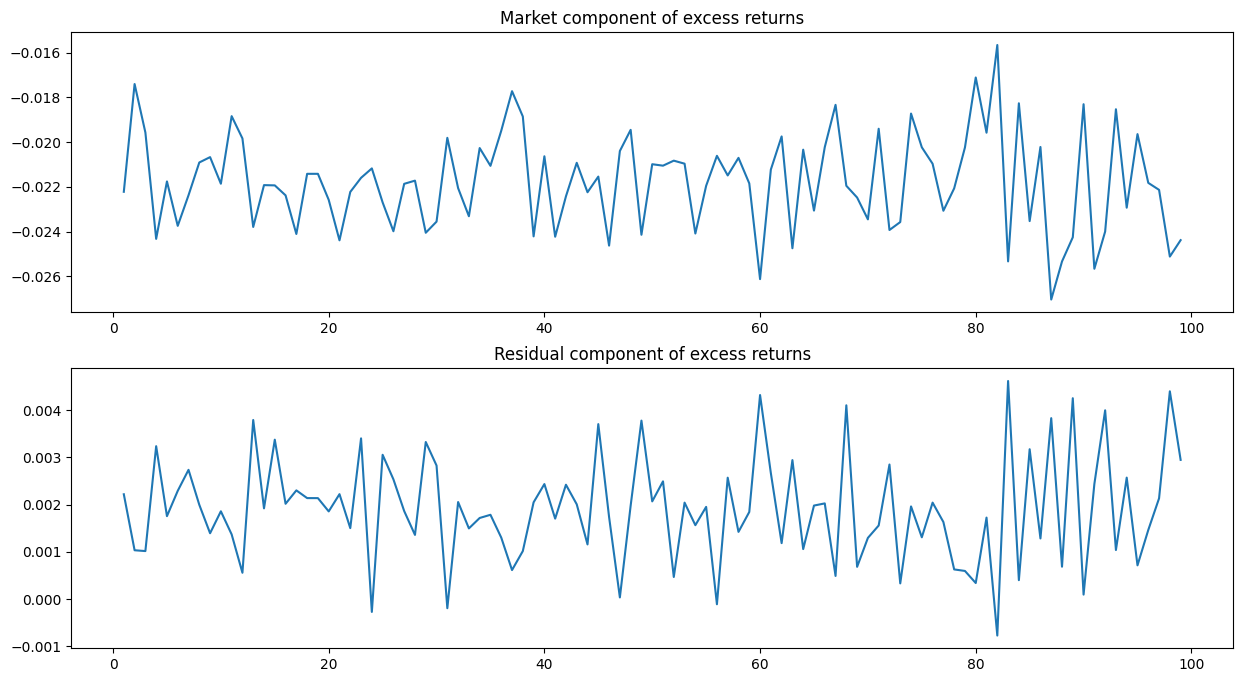

In [8]:
market_c = excess_btc*1.10324
residual_c = excess_bnb - market_c

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title("Market component of excess returns")
plt.plot(final_returns.index,market_c)
plt.subplot(212)
plt.title("Residual component of excess returns")
plt.plot(final_returns.index,residual_c)


### More on CAPM

The "sensible" implications of CAPM:

    Under CAPM, an individual whose portfolio differs from the market is playing a zero-sum game. They have additional risk with no additional expected return.
    CAPM taken literally implies that passive management is optimal. Residual risk is not what we would care about as it is self-imposed and avoidable.

Implications for portfolio management:

    Taking consensus expected returns from CAPM and plugging them into an optimizer yields the market portfolio.
    Alternatively we can take the market portfolio and assume it is optimal, and then back out the expected returns consistent with that assumption.




### Ex Post and Ex Ante CAPM

Let's expand the analysis to 2 more stocks ETH and ADA :


In [9]:
coin3 = 'ETHUSDT'
ETH_ticker = binance.fetch_ticker(coin3)
ETH_usdt_ohlcv = binance.fetch_ohlcv(coin3,'5m',limit=100)
df3=pd.DataFrame(ETH_usdt_ohlcv,columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df3['Date'] = pd.to_datetime(df3['Date'], unit = 'ms' )
coin3_returns = pd.DataFrame(np.diff(np.log(df3['Close'].values)))
coin3_returns.index = df3.index.values[1:df3.index.values.shape[0]]
coin3_returns.columns = [f'{coin3} Returns']

In [10]:
coin4 = 'ADAUSDT'
ADA_ticker = binance.fetch_ticker(coin4)
ADA_usdt_ohlcv = binance.fetch_ohlcv(coin4,'5m',limit=100)
df4=pd.DataFrame(ADA_usdt_ohlcv,columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df4['Date'] = pd.to_datetime(df4['Date'], unit = 'ms' )
coin4_returns = pd.DataFrame(np.diff(np.log(df4['Close'].values)))
coin4_returns.index = df4.index.values[1:df4.index.values.shape[0]]
coin4_returns.columns = [f'{coin4} Returns']

In [11]:
returns = pd.concat([coin3_returns,coin4_returns],axis=1).dropna()
excess_eth = returns["ETHUSDT Returns"].values - risk_free_rate
excess_tet = returns["ADAUSDT Returns"].values - risk_free_rate

In [12]:
mod = sm.OLS(excess_eth, exog)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     525.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.17e-41
Time:                        09:08:08   Log-Likelihood:                 549.68
No. Observations:                  99   AIC:                            -1095.
Df Residuals:                      97   BIC:                            -1090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.558      0.0

In [13]:
mod = sm.OLS(excess_tet, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     178.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.08e-23
Time:                        09:08:08   Log-Likelihood:                 507.79
No. Observations:                  99   AIC:                            -1012.
Df Residuals:                      97   BIC:                            -1006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.453e-05      0.001     -0.050      0.9

Text(0, 0.5, 'Expected Annual Return')

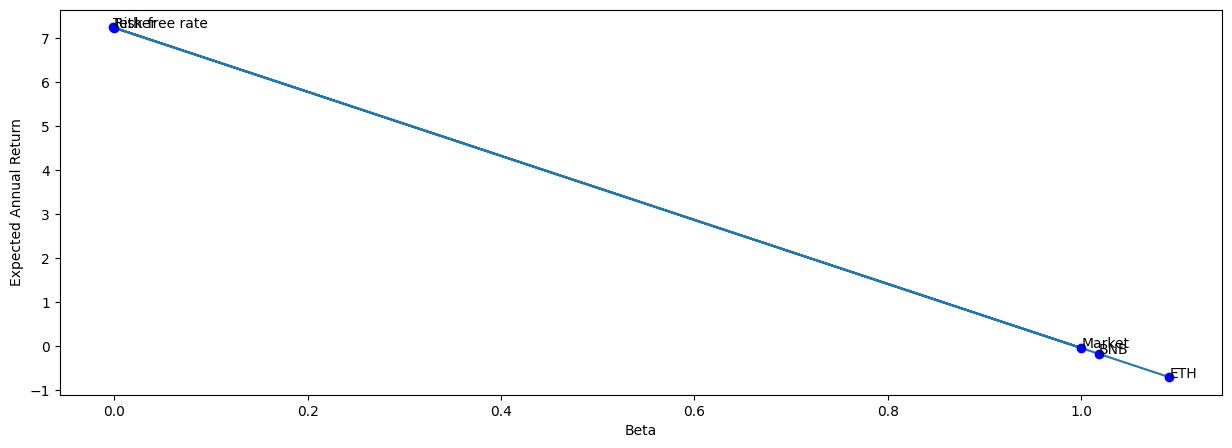

In [14]:
expected_btc = np.log(1+np.mean(excess_btc))*365
betas = np.array([0,1,-0.0017,1.0183,1.0912])
expected_rf = np.log(1+np.mean(risk_free_rate))*365
expected_returns = betas*expected_btc + expected_rf
data_names = ['Risk-free rate', 'Market','Tether','BNB','ETH']

plt.figure(figsize=(15,5))
plt.plot(betas,expected_returns)
plt.plot(betas,expected_returns,'bo')

for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns[i]))

plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")

Here the intercept is the risk-free rate, and the slope is equal to the expected excess return for the market. Now let's look at ex-post returns for the next year. We assume for simplicity that the betas and risk-free rate are the same:

In [15]:
df_new=df['Close'].values
df_annual=(df_new[df_new.shape[0]-1]/df_new[0] - 1)

df1_new=df1['Close'].values
df1_annual=(df1_new[df1_new.shape[0]-1]/df1_new[0] - 1)

df3_new=df3['Close'].values
df3_annual=(df3_new[df3_new.shape[0]-1]/df3_new[0] - 1)

df4_new=df4['Close'].values
df4_annual=(df4_new[df4_new.shape[0]-1]/df4_new[0] - 1)


expected_returns_real = [expected_returns[0],df_annual,df1_annual,df3_annual,df4_annual]
sml_real = np.array([0,1,1.0324,1.2319,1.2590])*df_annual
sml_real[0] = expected_returns[0]

C:\Users\super\AppData\Local\Temp\ipykernel_13448\989282768.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(betas,expected_returns_real,'bo',c='g',label='Realized Returns')
C:\Users\super\AppData\Local\Temp\ipykernel_13448\989282768.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(betas,sml_real,'bo',c='r')


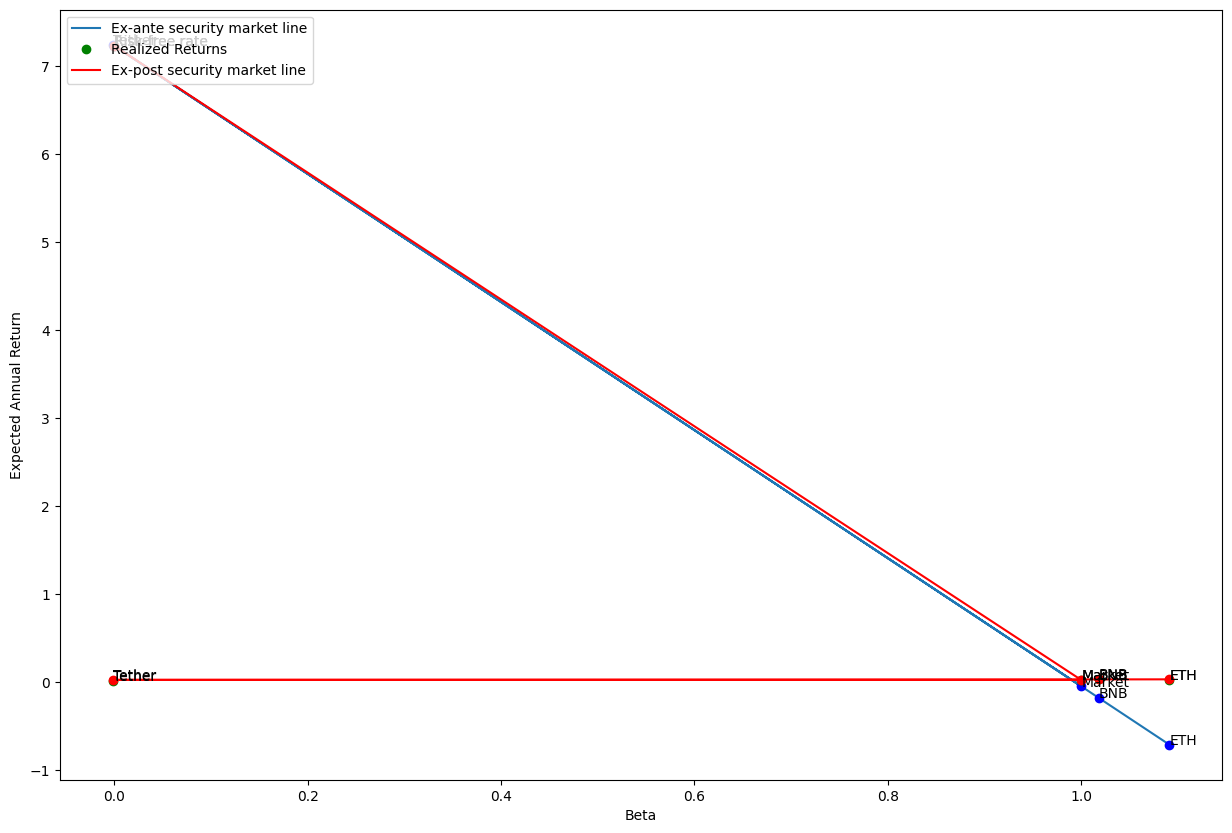

In [16]:
plt.figure(figsize=(15,10))

plt.plot(betas,expected_returns,label='Ex-ante security market line')
plt.plot(betas,expected_returns,'bo')
plt.plot(betas,expected_returns_real,'bo',c='g',label='Realized Returns')

plt.plot(betas,sml_real,c='r',label='Ex-post security market line')
plt.plot(betas,sml_real,'bo',c='r')  

for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns[i]))
  
for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],sml_real[i]))    
    
for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns_real[i]))
    
plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")
plt.legend(loc=2)



Here the ex-post SML tells us the component of return that CAPM would have forecast if we had known how the market portfolio was going to perform. The slope is negative since the market returned less than the risk-free rate in this period.

Another way to visualize CAPM is by plotting daily excess returns from a stock and the market. Here we plot excess returns for Amazon against the S&P500 for the period 2012-2014:


Text(0.5, 0, 'BNBUSDT Returns')

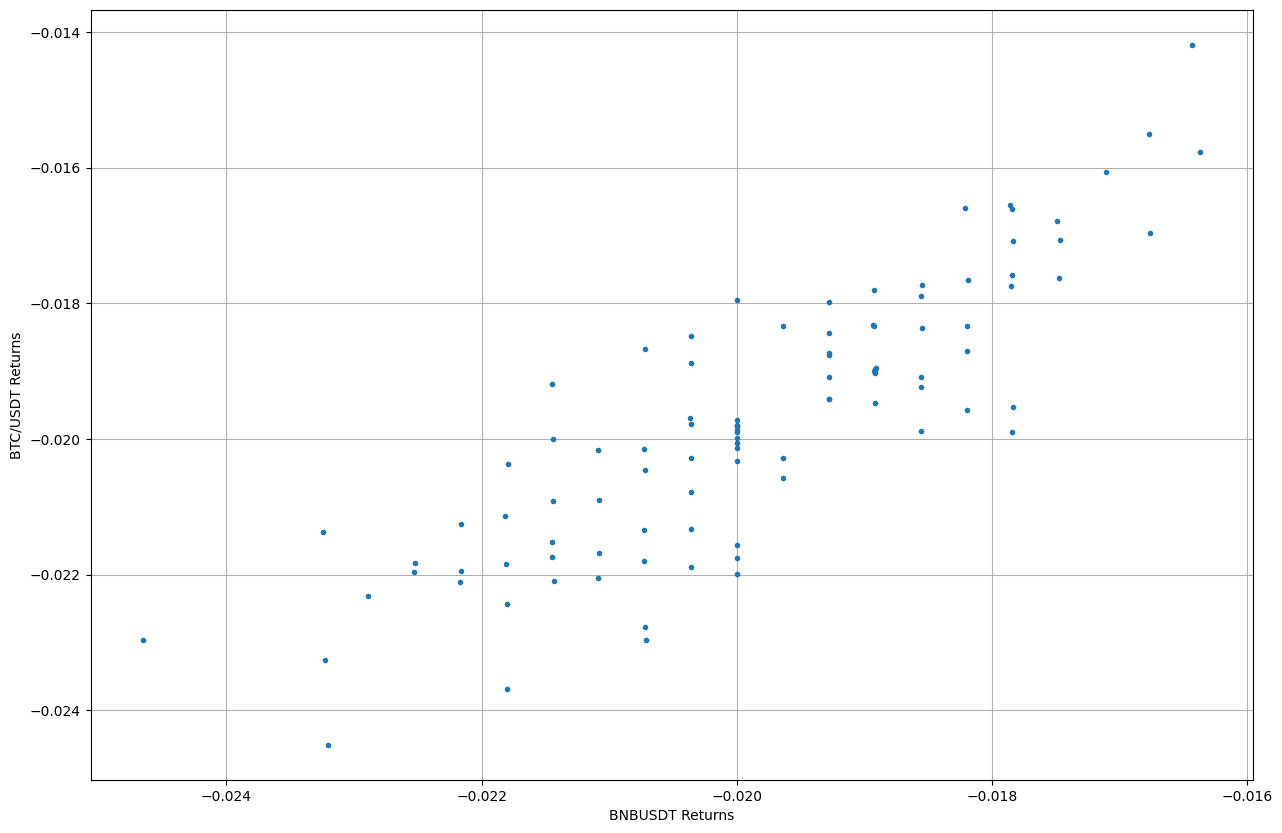

In [17]:
plt.figure(figsize=(15,10))
plt.plot(excess_bnb,excess_btc,'.')
plt.grid(True)
plt.ylabel(f'{coin} Returns')
plt.xlabel(f'{coin2} Returns')


### CAPM and Relevance for Active Managers

CAPM works well compared to the naive hypothesis that the expected returns on all stocks are the same, but less well when we test the hypothesis that

is 0. As for relevance for active managers, on the surface CAPM looks not particularly useful given its implications, but it is still useful as a benchmark by which to evaluate value-added by the active manager.

CAPM can also help an active manager distinguish between market and residual components of return. This decomposition can help managers avoid taking active market positions by allowing them to take portfolio betas closer to 1 (i.e. it allows them to avoid the risk of market timing and to focus research on residual returns that have a consensus expectation of zero).
### CAPM and Forecasting

    Need to have forecasts of betas! Simplest is historical measure; more advanced: state space modelling.
    Need to have forecasts of expected excess market returns! Same options as above.

